# ODSC 2025 RAG + Structured Generation with Outlines

In this lesson, we'll be covering how to use Retrieval-Augmented Generation (RAG) to search for product reviews relevant to a question and then generate structured data from the reviews. We'll have well-structured data at the end that we can use for later analysis.

At the end of this lesson, you'll be able to:

- Use RAG (via [Milvus](https://milvus.io/)) to search for product reviews relevant to a question
- Use LLMs and [Outlines](https://github.com/dottxt-ai/outlines) to generate structured data from the reviews to understand sentiment for various categories
- Visualize the results using PCA

The lesson is structured as follows:

1. Load the dataset
2. Preprocess the data
3. Set up the vector database for RAG
4. Use LLMs and Outlines to generate structured data from the reviews
5. Visualize the results using PCA

## Definitions

Before we get started, let's define a few terms. Some of you may not be familiar with all of these terms, but that's okay! We'll be using them throughout the lesson.

### Retrieval-augmented generation (RAG)

RAG stands for retrieval-augmented generation. It's a technique that allows us to use a large language model (LLM) to generate text that is relevant to a specific question. For example, we can use RAG to search for product reviews that are relevant to a question like "How do people feel about our prices?".

RAG is a good way to find text that is "similar" to a question, and placing it into a language model's context window so that the model can use it to generate a response.

### Outlines + structured generation

Outlines is an open-source framework for structured generation. Structured generation is a technique that allows us to use a large language model (LLM) to generate text that is structured in a specific way. For example, we can use structured generation to generate a list of categories that a user's experience falls into and provide a sentiment for each category.

[DIAGRAM HERE]

## Setup

You will need to install the following packages:

```bash
pip install "pymilvus[model]" "outlines[transformers]" datasets sentence-transformers scikit-learn matplotlib pandas einops sentencepiece
```

You may also install the package from the `requirements.txt` file in the repository:

```bash
pip install -r requirements.txt
```


## Configuration

The following variables can be set to configure the lesson, depending on your hardware. 

- `sample_size`: the number of reviews to use for the lesson. If you have a GPU, you can set this to a higher number.
- `overwrite_data`: if True, `embeddings.npz` and `videogames.csv` will be overwritten. I recommend setting this to `False`, as you will have to recompute embeddings.
- `device`: the device to use for the lesson. If you have a GPU, you can set this to `cuda`. If you have an Apple Silicon GPU, you can set this to `mps`. If you don't have a GPU, you can set this to `cpu`.


In [1]:
# Configuration
sample_size = None # to use the full dataset, set this to None. Be warned! This will take a long time to run.
overwrite_data = False # if True, embeddings.npz and videogames.csv will be overwritten
device = 'auto' # 'mps' or 'cpu' or 'auto'

# If overwrite_data is True, make a backup of the database and the embeddings before running the code.
if overwrite_data:
    import shutil
    shutil.copy("product-reviews.db", "product-reviews-backup.db")
    shutil.copy("embeddings.npz", "embeddings-backup.npz")



## Load the dataset

We'll be working with a dataset of Amazon reviews for video games, provided by the [McAuley Lab](https://cseweb.ucsd.edu/~jmcauley/).

The dataset is available on [Hugging Face](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023).

We'll load the dataset using the `datasets` library. It may take a few seconds to download, so please be sure to start it early. It took me about 1.5 minutes to download the dataset.

In [2]:
if overwrite_data:
    from datasets import load_dataset

    dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023", 
        "raw_review_Video_Games", 
        trust_remote_code=True,
        cache_dir="cache",
        split="full"
    )
    df = dataset.to_pandas()

    # Change the title column to be the "review_title" column
    df.rename(columns={'title': 'review_title'}, inplace=True)

Next, we need to download the metadata for the dataset. This metadata contains information about the product, such as the product title, description, and other attributes. We primarily need the product title.

Downloading the metadata may take 30-60 seconds.

In [3]:
if overwrite_data:
    meta_dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023", 
        "raw_meta_Video_Games", 
        trust_remote_code=True,
        cache_dir="cache",
        split="full"
    )

    meta_df = meta_dataset.to_pandas()

    # Change the title column to be the "product_title" column
    meta_df.rename(columns={'title': 'product_title'}, inplace=True)


Next, we need to join the two datasets on the `parent_asin` column. This will allow us to get the product title for each review.

`parent_asin` is the product ID for the product that the review is for. Some products on Amazon have multiple versions (`asin`), so the `parent_asin` is the same for all versions of the product.

In [4]:
import pandas as pd

if overwrite_data:
    # Join the two datasets on the parent_asin column
    joined_df = df.merge(meta_df, on='parent_asin', how='inner')

That's a lot of data! Let's try and find a few products that we can work with more easily.

In [5]:
if overwrite_data:
    # Count products 
    print(joined_df.groupby(['parent_asin', 'product_title']).size().sort_values(ascending=False).head(50))


I've selected a few games that I think will be interesting to work with, as most people have likely heard the name. These games are also well reviewed on Amazon.

- Minecraft `B00BU3ZLJQ`
- The Legend of Zelda: Breath of the Wild `B087NNPYP3`
- Assassin's Creed IV: Black Flag `B00BN5T30E`
- The Elder Scrolls V: Skyrim (Playstation 4) `B07YBXFDYN`

I also add some timestamp parsing tools to make it easier to work with the data.

In [6]:
# Add date parsing tools
from datetime import datetime, timezone

if overwrite_data:
    # Filter the dataset to only include the selected games
    videogames = joined_df[joined_df['parent_asin'].isin(['B00BU3ZLJQ', 'B087NNPYP3', 'B00BN5T30E', 'B07YBXFDYN'])]

    # Select only the columns we need
    columns = ['parent_asin', 'product_title', 'review_title', 'text', 'rating', 'timestamp', 'user_id']
    videogames = videogames[columns]

    # Remove rows where either review_title or text is NaN/null
    videogames = videogames.dropna(subset=['review_title', 'text'])
    
    if overwrite_data:
        videogames.to_csv("videogames.csv", index=True)
else:
    videogames = pd.read_csv("videogames.csv", index_col=0)

    # Remove rows where either review_title or text is NaN/null
    videogames = videogames.dropna(subset=['review_title', 'text'])

    

# Parse the timestamp column from unix time to a datetime object
videogames.loc[:, 'timestamp'] = videogames['timestamp'].astype(int).map(lambda x: datetime.fromtimestamp(x/1000, tz=timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ'))

/tmp/ipykernel_81305/2942070065.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2016-12-18T02:56:36Z' '2016-12-25T16:13:30Z' '2017-03-16T06:39:04Z' ...
 '2014-07-02T00:53:26Z' '2011-12-30T00:14:48Z' '2014-11-29T18:39:39Z']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  videogames.loc[:, 'timestamp'] = videogames['timestamp'].astype(int).map(lambda x: datetime.fromtimestamp(x/1000, tz=timezone.utc).strftime('%Y-%m-%dT%H:%M:%SZ'))


RAG and structured generation are both computationally expensive operations, so we'll want to keep the dataset small for exploration purposes. We have to calculate an [embedding](https://platform.openai.com/docs/guides/embeddings) for each review, so we'll want to keep the dataset small to avoid having to wait too long for results.

This is still a relatively large dataset. If you have not downloaded the prepared dataset, you can set the sample size to 100-200 to keep the computation time manageable. If you have a GPU, you can increase the sample rate.

In [7]:

# Downsample the dataset if sample_size is set
if sample_size is not None:
    videogames = videogames.sample(n=sample_size, random_state=42)


Great! Now we have a dataset of reviews for 4 games. Let's take a look.

In [8]:
videogames.head()

,parent_asin,product_title,review_title,text,rating,timestamp,user_id
366,B00BN5T30E,Assassin's Creed IV Black Flag - PC,Five Stars,Great Game,5.0,2016-12-18T02:56:36Z,AFEJ2MZWR7O64X2S3ZI2J7BFKTYA
1018,B07YBXFDYN,Skyrim VR - PlayStation 4,Legendary,The BEEST game anyone could ever buy. Literall...,5.0,2016-12-25T16:13:30Z,AG6OZNFZE6P52PW2PA5WF2IAHKLA
1079,B07YBXFDYN,Skyrim VR - PlayStation 4,Five Stars,My son likes this,5.0,2017-03-16T06:39:04Z,AEUECZFYVQCQ7OFZ2SQWYAP64GJA
1174,B087NNPYP3,The Legend of Zelda: Breath of the Wild Master...,Must buy for switch,My main reason for buying a switch. And with a...,5.0,2019-09-26T17:31:08Z,AFWRGOGF4AI2IHRX7KZ2IYL63RXA
1363,B087NNPYP3,The Legend of Zelda: Breath of the Wild Master...,The promise of additional content for a tremen...,I recently purchased the &#34;The Legend of Ze...,5.0,2017-04-04T04:44:38Z,AHTBBASAHXHHOXKLSSZG2IPUDDFA


## Quick primer on embeddings

Embeddings are a way to represent text as a vector of numbers. This vector of numbers communicates the __meaning__ of the text to the embedding model -- for example, the embeddings for "cat" and "dog" are close to each other in the embedding space, while the embeddings for "cat" and "car" are far apart.

Let me show you an example. First, we need to set up our embedding model.In this case, we'll be using the [mxbai-embed-xsmall-v1](https://huggingface.co/mixedbread-ai/mxbai-embed-xsmall-v1) model to embed the reviews. If you're running this for the first time, you will need to allow the server to download the model.

In [10]:
from sentence_transformers import SentenceTransformer

# Choose an embedding model
embedding_model = SentenceTransformer(
    "mixedbread-ai/mxbai-embed-xsmall-v1",

    # If you want better performance, use the large model:
    # "mixedbread-ai/mxbai-embed-large-v1",

    # You can change the embedding device to 'mps' or 'cpu' if you have a more powerful computer
    # device=device
)

As I mentioned before, embeddings are a way to represent text as a vector of numbers. Let's take a look at the embedding space for a few documents.

Don't worry too much about what's going on in this code block -- all we're doing is 

1. Calculating the embeddings for a few documents
2. Reducing the dimensionality of the embeddings from 768 many dimensions to 2 dimensions so we can visualize them

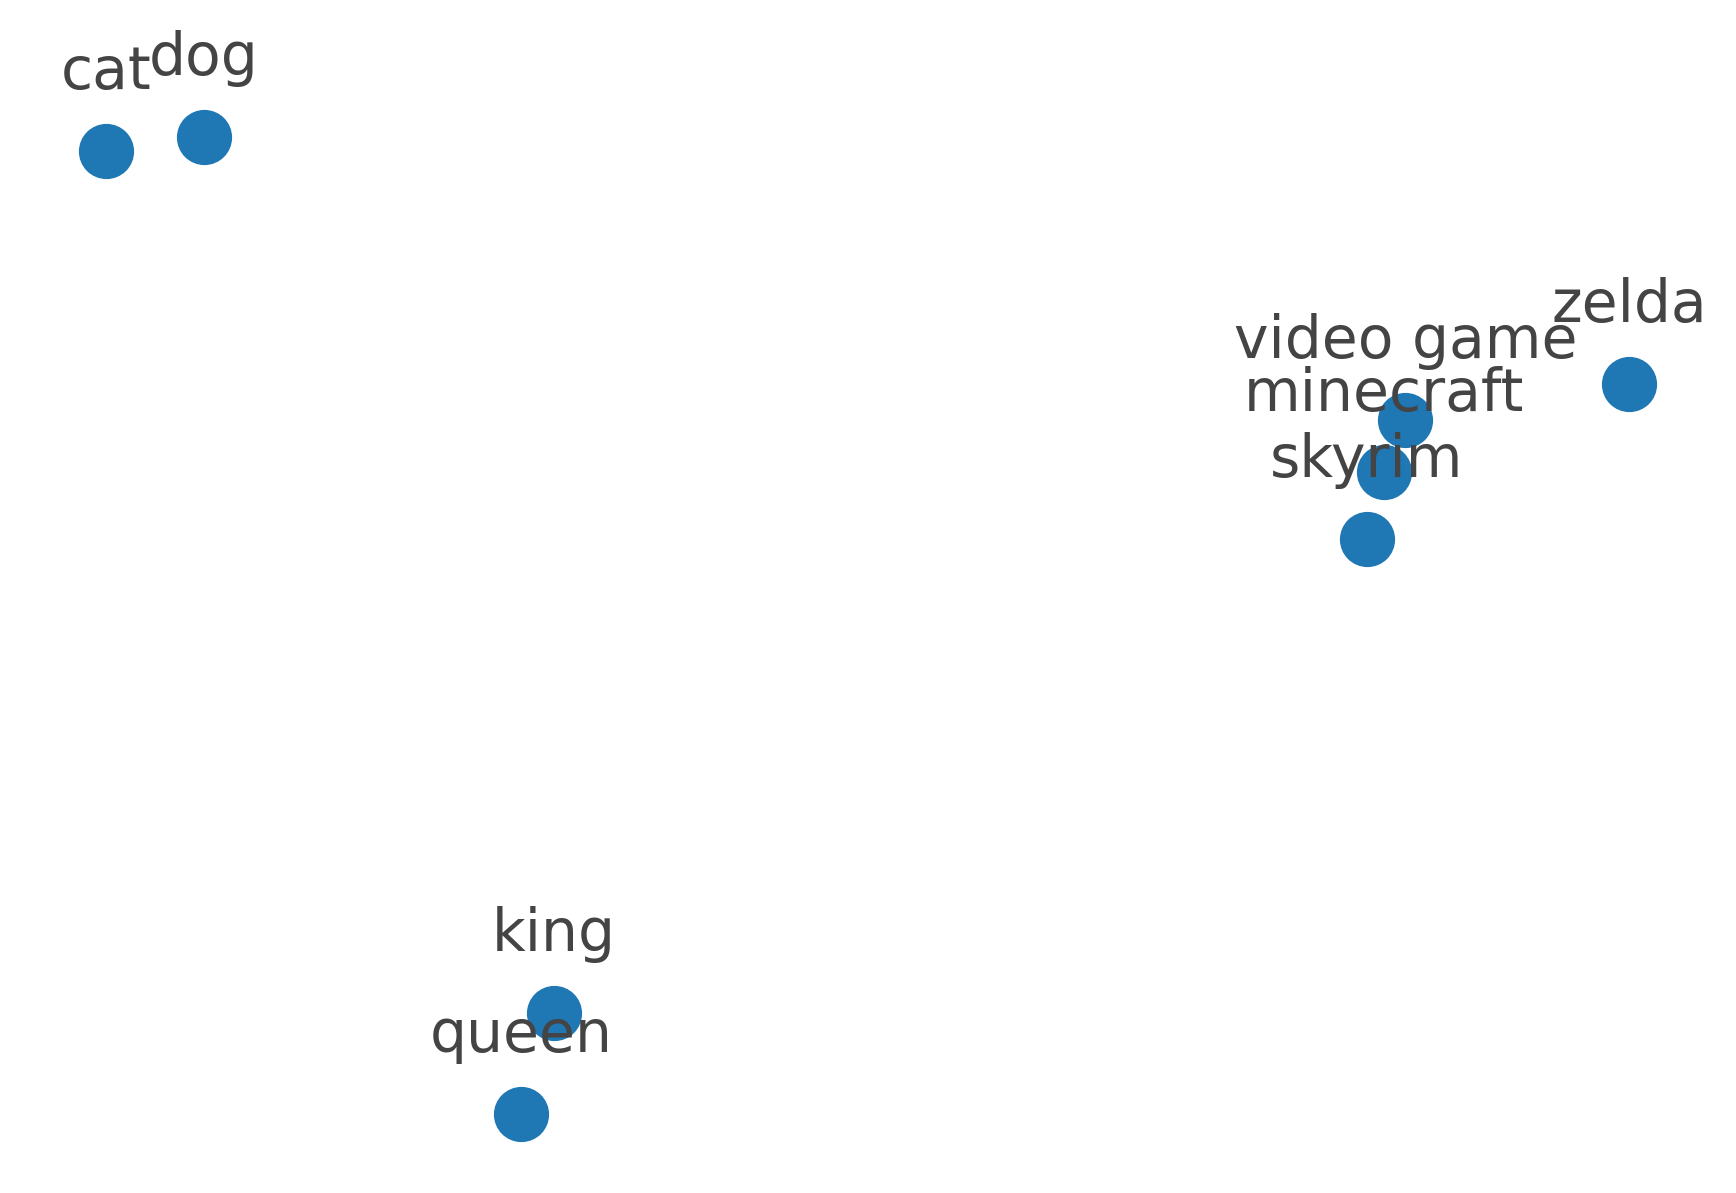

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

documents = ["cat", "dog", "king", "queen", "video game", 'minecraft', 'zelda', 'skyrim']
vectors = embedding_model.encode(documents)

# Show the principle components of the embedding space
pca = PCA(n_components=2)
transformed = pca.fit_transform(vectors)

# Create the scatter plot with a white background
plt.figure(figsize=(6,4), facecolor='white', dpi=300)
ax = plt.gca()

# Remove axes and grid
ax.set_axis_off()

# Make the scatter plot cuter with larger, semi-transparent dots
plt.scatter(
    transformed[:, 0], 
    transformed[:, 1], 
    s=150,  # Larger dots
)

# Add labels above each point with a nicer font
for i, doc in enumerate(documents):
    plt.annotate(doc, 
                (transformed[i, 0], transformed[i, 1]),
                xytext=(0, 12),  # Slightly higher offset
                textcoords='offset points',
                ha='center',  # horizontal alignment
                va='bottom',  # vertical alignment
                fontfamily='sans-serif',
                fontsize=14,
                color='#444444')  # Darker gray for better readability

# Add some padding around the plot
plt.tight_layout(pad=1.5)
plt.show()

Note that the embeddings for "cat" and "dog" are close to each other, as are "king" and "queen". Video games are close to each other and form a cluster.

When we do RAG, all we are doing is finding embeddings that are close to the query embedding. Let me add a query to the embedding space and see what happens.

In [11]:
# Calculate the query vector
query = "What's that one game with the big dragon?"
query_vector = embedding_model.encode([query])

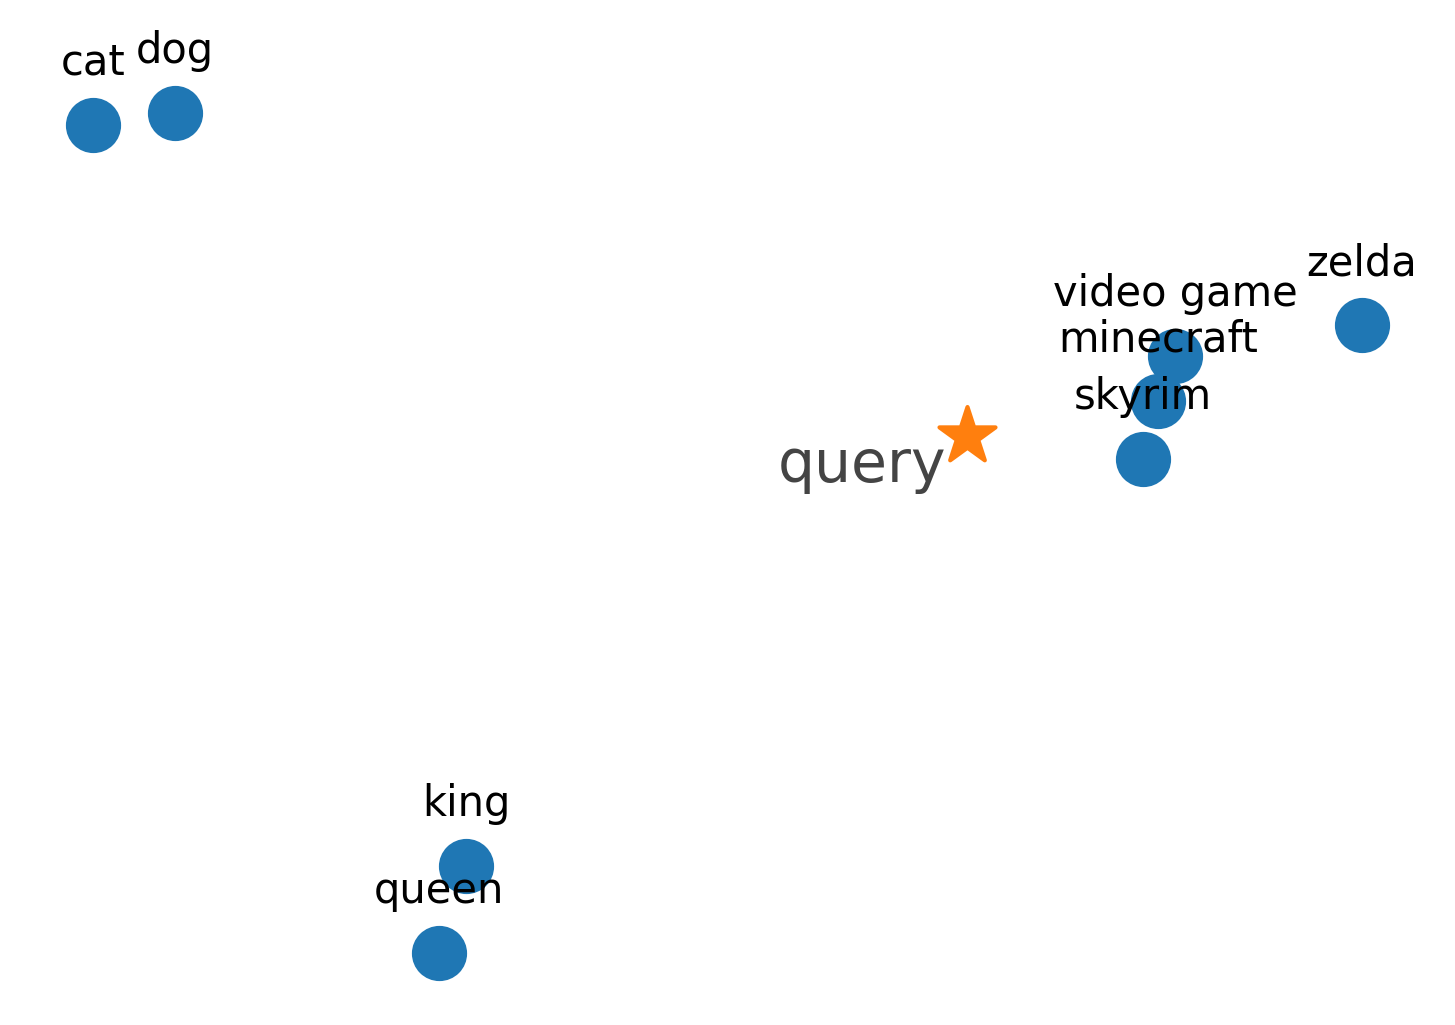

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

documents = ["cat", "dog", "king", "queen", "video game", 'minecraft', 'zelda', 'skyrim']
vectors = embedding_model.encode(documents)

# Show the principle components of the embedding space
pca = PCA(n_components=2)
transformed = pca.fit_transform(vectors)
transformed_query = pca.transform(query_vector[0].reshape(1, -1))

# Create the scatter plot with a white background
plt.figure(figsize=(6,4), facecolor='white', dpi=300)
ax = plt.gca()

# Remove axes and grid
ax.set_axis_off()

# Make the scatter plot cuter with larger, semi-transparent dots
plt.scatter(
    transformed[:, 0], 
    transformed[:, 1], 
    s=150,  # Larger dots
)

# Add labels above each point
for i, doc in enumerate(documents):
    plt.annotate(doc, 
                (transformed[i, 0], transformed[i, 1]),
                xytext=(0, 10),  # 10 points vertical offset
                textcoords='offset points',
                ha='center',  # horizontal alignment
                va='bottom') # vertical alignment

# Add the query point with a different style
plt.scatter(
    transformed_query[0][0], 
    transformed_query[0][1], 
    marker='*',  # Star marker instead of X
    s=200,  # Larger size for emphasis
)

# Add query label
plt.annotate('query', 
            (transformed_query[0][0], transformed_query[0][1]),
            xytext=(-25, 0),  # Place label to left
            textcoords='offset points',
            ha='center',
            va='top',
            fontfamily='sans-serif',
            fontsize=14,
            color='#444444')

plt.show()

**Try it out!** Play around with the query to see how it changes the results. Try adding a few other documents and seeing where they are in embedding space.

In practice, we don't visualize the embedding space for RAG purposes. Embeddings are simply too-high dimensional, and there are often too many documents to visualize.
 
We use a metric called __cosine similarity__ to find the most similar documents to a query. Cosine similarity is a measure of how similar two embedding vectors are in "meaning".

Here's an example of how we can calculate the cosine similarity between a query and a document.

In [13]:
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

for (doc, vector) in zip(documents, vectors):
    print(f"{doc:<12}{cosine_similarity(query_vector[0], vector):.2f}")


cat         0.23
dog         0.23
king        0.36
queen       0.29
video game  0.43
minecraft   0.36
zelda       0.42
skyrim      0.48


This is what vector databases like Milvus do, albeit more efficiently. You upload embedding vectors, and query the database using a query vector. Let's see how this works in practice.

## Returning to the dataset

Now we've introduced embeddings, we can return to the dataset and how we can put it into a vector database.

We want to upload embeddings to the vector that contain as much semantic information as possible. In this case, I've chosen to create a single string for each review that contains the review title, text, product title, and rating.

In [14]:
# Preprocess the text -- compacts the r eview title, text, and product title into a single string
def preprocess_text(row):
    product_title_row = "Review for product: " + row['product_title']
    review_title_row = "Review Title: " + row['review_title']
    rating_row = "Rating: " + str(row['rating'])
    review_text_row = "Review Text: " + row['text']
    return f"{product_title_row} \n{review_title_row} \n{rating_row} \n{review_text_row}"

videogames.loc[:, 'processed_text'] = videogames.apply(preprocess_text, axis=1)


In [15]:
print(videogames.processed_text.iloc[5])

Review for product: The Legend of Zelda: Breath of the Wild Master Edition - Nintendo Switch 
Review Title: Fantastic game so far! 
Rating: 5.0 
Review Text: I recently purchased the Nintendo Switch version of the game &#34;The Legend of Zelda: Breath of the Wild&#34; and I must say I am very pleased with it!<br /><br />Keep in mind I haven't played it for very long, ..but this game appears to be simply awesome!<br /><br />Breath of the Wild definitely looks like a game that I am going to be playing for a long, long time to come.  The sheer size and depth of the world (and it's gameplay) seems incredible.<br /><br />As a huge fan of the Zelda series I was hoping this game would be something special.. and that most definitely seems to be the case!


# Using Milvus

[Milvus](https://milvus.io/) is a vector database that allows us to store and search embeddings. You should think of vector databases as a tool to search for items with similar "meaning" to a query.

We'll be using the `pymilvus` library to interact with Milvus.

```bash
pip install "pymilvus[model]"
```

Let's connect to the Milvus database.


In [16]:
from pymilvus import MilvusClient

# Create or connect to the database. This will place the database 
# in the current working directory with the name "product-reviews.db".
client = MilvusClient("product-reviews.db")

# This part will clear the vector database if overwrite_data is True. Be careful!
# The database will be deleted if you run this again.
if overwrite_data:
    # Drop the collection if it already exists.
    # This is a good practice to ensure that we start fresh.
    # If you're running this for the first time, you can skip this step.
    if client.has_collection(collection_name="product_reviews"):
        client.drop_collection(collection_name="product_reviews")

    client.create_collection(
        collection_name="product_reviews",
        dimension=384,  # The vectors we will use in this demo has 768 dimensions
    )
else:
    client.load_collection('product_reviews')
    

Notice how much information is preserved in the processed text. We have the name of the product, the review title, the rating, and the review text. Any vector search will be able to use this information to find the most relevant reviews. You may wish to remove the product title to allow the embeddings to focus on the review text -- this is a good exercise for you to try!

Next, we'll upload the embeddings to the vector database. This is one of the more computationally expensive operations, so it may take a few seconds to complete depending on your hardware.

In [17]:
# Create a DataFrame to store embeddings with their corresponding IDs
import os

if not overwrite_data:
    # Load the embeddings and IDs from disk
    embeddings_data = np.load("embeddings.npz", allow_pickle=True)
    vectors = embeddings_data['vectors']
    vector_ids = embeddings_data['ids']
else:
    # Text strings to search
    docs = videogames.processed_text.tolist()
    # Store original index before encoding
    vector_ids = videogames.index.tolist()
    vectors = embedding_model.encode(docs)

    # Remove any existing embeddings and IDs
    if os.path.exists("embeddings.npz"):
        os.remove("embeddings.npz")

    # Save both embeddings and IDs to disk
    np.savez("embeddings.npz", vectors=vectors, ids=vector_ids)

# Create a mapping between original IDs and vectors
embeddings_map = dict(zip(vector_ids, vectors))

`embeddings_map` contains the embeddings for each review by ID. We can use this to look up the embeddings for each review. The only reason we need to do this is for people who are downloading the embeddings from disk -- the order of the embeddings is not guaranteed to match the order of the reviews.

Let's upload the embeddings to the vector database.

In [18]:
# Each entity has id, vector representation, raw text, and a subject label that we use
# to demo metadata filtering later.
data = []

for row in videogames.itertuples():
    data.append({
        'id':row.Index, 
        'vector':embeddings_map[row.Index].tolist(), 
        'text':row.processed_text,
        'product_title': row.product_title,
        'parent_asin': row.parent_asin,
        'rating': row.rating,
        'timestamp': row.timestamp,
        'user_id': row.user_id,
    })

print("Data has", len(data), "entities, each with fields: ", data[0].keys())
print("Vector dim:", len(data[0]["vector"]))


Data has 23074 entities, each with fields:  dict_keys(['id', 'vector', 'text', 'product_title', 'parent_asin', 'rating', 'timestamp', 'user_id'])
Vector dim: 384


Milvus uses `client.insert` to upload data to the vector database. We simply provide the collection name and the data to upload. This may take some time if you have a large dataset.

This will clear the vector database if `overwrite_data` is `True`. Note that inserting documents into Milvus can be slow, so be sure to set `overwrite_data` to `False` if you are not sure. Leaving the default value of `False` means you will use the existing vector database.

In [19]:
if overwrite_data:
    client.insert(collection_name="product_reviews", data=data)

We can also visualize the embedding space of the product reviews:

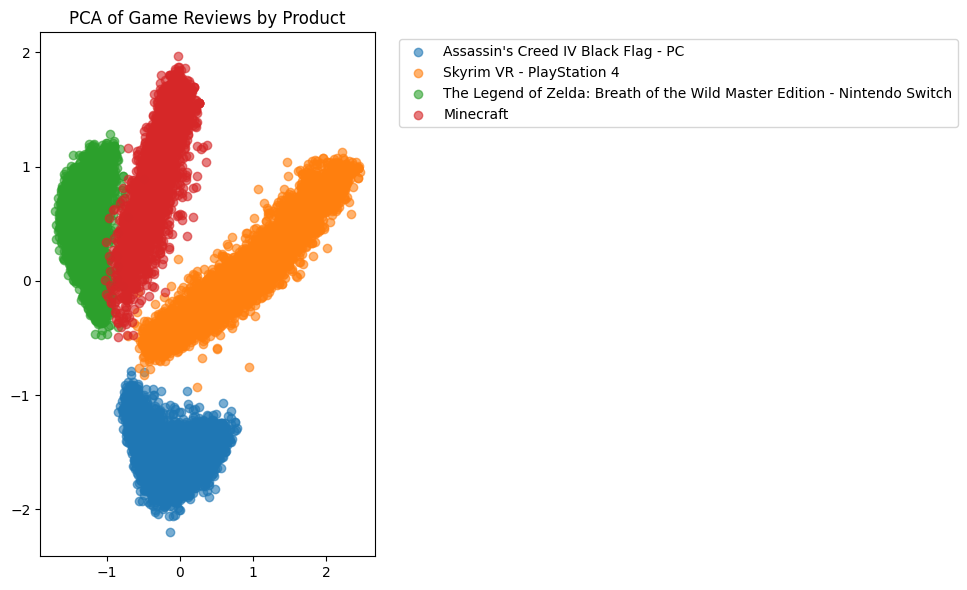

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Create PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(vectors)

# Create color map
unique_products = videogames['product_title'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_products)))
color_dict = dict(zip(unique_products, colors))

# Create scatter plot
plt.figure(figsize=(10, 6))
for product in unique_products:
    mask = videogames['product_title'] == product
    plt.scatter(
        transformed[mask, 0], 
        transformed[mask, 1],
        label=product,
        alpha=0.6
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA of Game Reviews by Product')
plt.tight_layout()
plt.show()

## Searching the vector database

We have now uploaded the data to the vector database, which means we can perform semantic search on the data.

We need to pick a question that will determine which reviews are relevant to the question. 

Suppose we want to know about prices. Are our prices too low? Too high?

I'll propose a question that will determine which reviews are relevant to the question. I've phrased it to be general enough to be relevant to all of the products in our dataset, and I've attempted to keep the question from focusing on high or low prices specifically.

In [21]:
question = """
How do people feel about our prices? I'm trying to understand how people feel about our prices, 
both good and bad.
"""

Vector search compares the query vector to the vectors in the database. The query vector is the embedding for the question we want to ask our database.

In [22]:
# Embed the query and convert the resulting embedding to a list
query_embeddings = [
    m.tolist() 
    for m in embedding_model.encode([question])
]

Let's search the database using the query vector.

The `limit` parameter determines how many results we want to return -- set this to a lower number if your computer is not powerful.

In [23]:
res = client.search(
    collection_name="product_reviews",
    data=query_embeddings,
    limit=10,
    output_fields=[
        "text", 
        "product_title", 
        "parent_asin", 
        "asin", 
        "rating", 
        "timestamp", 
        "helpful_vote", 
        "verified_purchase", 
        "user_id", 
        "review_title",
        'id'
    ],
)

print(res[0][0]['entity']['text'])

 
Review Title: Expensive but good. 
Rating: 4.0 
Review Text: Price is going up and not down, otherwise a good game.


Finally, let's extract the text from the search results to pass them to the LLM.

In [24]:
# Get the resulting query text
# Note: we only provided a single query, so we take the 0th result.
# Milvus search queries are lists by default.
reviews = [doc['entity']['text'] for doc in res[0]] 


# Using Outlines


Outlines is a framework for structured generation. It allows us to use a large language model (LLM) to generate text that is structured in a specific way.

We are going to use the `Qwen/Qwen2.5-1.5B-Instruct` model. This is a small model that is fast and cheap to run. Most computers should be able to run thi, albeit slowly.

Model selection is an important part of any language model project. The larger models will generally give better results, but will also be slower and memory-intensive. As this is a workshop designed for a general audience, we will use the smaller model.


In [29]:
import outlines
from transformers import BitsAndBytesConfig

# model_string = 'Qwen/Qwen2.5-0.5B-Instruct' # If you can't run the 1.5B model, use this one
model_string = 'Qwen/Qwen2.5-1.5B-Instruct'

llm = outlines.models.transformers(
    model_string,
    device=device,
)

Outlines does not add chat template tokens to the model, so we need to add them manually. Chat template tokens are special tokens used in instruction-tuned models to indicate system prompts, user prompts, and assistant prompts.

Failing to include chat template tokens will cause the model to generate text with unpredicatable results. The output will _always_ conform to the schema, but the actual text may be nonsensical or incorrect.

`transformers` provides an `AutoTokenizer` class that can be used to easily apply chat template tokens to the model.


In [30]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_string)

# Simple template function
def template(
        user_prompt: str, 
        system_prompt: str="You are a helpful assistant assisting an analyst analyzing product reviews."
    ):
    return tokenizer.apply_chat_template(
        [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}],
        tokenize=False,
        truncation=True,
        add_bos_token=True,
        add_generation_prompt=True
    )

print(template("Hello"))

<|im_start|>system
You are a helpful assistant assisting an analyst analyzing product reviews.<|im_end|>
<|im_start|>user
Hello<|im_end|>
<|im_start|>assistant



Note the `<|im_start|>system`, `<|im_start|>user`, and `<|im_end|>` tokens. These are the system prompt and user prompt tokens. 

We insert a trailing `<|im_start|>assistant` token to indicate the beginning of the assistant prompt. This can help the model understand that it is responding to the prompt. Not including this token can cause unpredictable results.

Let's compare the two outputs. We'll use the unstructured text generator to compare the two outputs. A `generator` is a function that takes a prompt and returns language model output. To return structured data, we typically construct the generator with `outlines.generate.json`. You may also use `outlines.generate.text` to return unstructured text.

Here is how to initialize the unstructured text generator:

In [31]:
# Generator function to produce arbitrary responses
generator = outlines.generate.text(llm)

Here is the result with and without the chat template tokens:

In [32]:
print("Without chat template tokens:")
print(generator("Hello", max_tokens=10))

print("\nWith chat template tokens:")
print(generator(template("Hello"), max_tokens=10))

Without chat template tokens:
 怎样得到国务院办公厅的发文字号

With chat template tokens:
Hello! How can I assist you with analyzing product


Note that the untemplated response is confusing and nonsensical. The templated response is consistent with our general experience of talking to chatbots and other instruction-tuned models.

## Using Outlines to extract structured data with a language model

The next part is to choose a few pieces of structured data that we would like to extract from the reviews.

We typically define the structure of the data we want to extract by defining a Pydantic class. Pydantic is a library that allows us to define strongly-typed data structures.

Outlines will force the language model to output data in the format you specify -- think of it as defining a "shape" of the response, and then allowing the model to fill in the details.

Let's take a look at a review.

In [33]:
print(reviews[2])

 
Review Title: Great pricing from this reseller 
Rating: 4.0 
Review Text: This reseller has great pricing


Great -- spot checking this, it seems to be about prices. Our vector search worked well!

Let's define the data we want to extract from the reviews. To start, we'll just define a general response to the question.

In [34]:
from pydantic import BaseModel

class Answer(BaseModel):
    feedback_summary: str
    answer: str


We have the structure we want to extract, so let's create the generator. 

`outlines.generate.json` is a generator that takes a prompt and returns a structured response.

In this case, we know that the result of the generator will be a `Answer` object.

In [35]:
# This function will take an arbitrary review string and
# return a structured `Answer` object.
review_generator = outlines.generate.json(llm, Answer)

We can test what it looks like with random input:

In [36]:
print(review_generator("This is a great game!"))

feedback_summary='' answer="My sincerest apologies, but I'm unable to classify or summarize specific games as I do not have real-time internet access or personal experience with games. I recommend checking a reliable gaming news website or app for game reviews and summaries."


Great. Next, we need to prompt our model, as you would in any language model context.

You still have to provide good prompts. Structured generation is not a magic bullet. You will always get the structure you specify, but good prompting will improve the quality of the output.

**Your turn!** Experiment with the prompt below. Can you help the model produce more useful output?

In [37]:
def answer_prompt(question: str, reviews: str):
    return template(f"""
    Please see a list of reviews for one or more products. Analyze the reviews and provide
    an answer to my question.

    Respond in JSON format, following the schema: {Answer.model_json_schema()}

    My question is: {question}

    # Begin review

    {reviews}
    """)

The function `review_prompt` takes a review and returns a chat-templated prompt for the language model.

We can now use the `review_generator` to generate structured data from the reviews. This is where the language model is used -- it can be slow depending on your hardware. If you need to speed it up, you can reduce the number of reviews returned by the vector search (the `limit` keyword) earlier in the lesson.

In [38]:
# Generate structured data from the reviews
reviews_all = "\n\n".join(reviews)
review_result = review_generator(answer_prompt(reviews_all, question))

What do the results look like? Let's see!

In [39]:
# Print the first result
print(review_result)

feedback_summary='People generally feel satisfied with the pricing, with some mentioning that the prices are good and sometimes that they were ' answer='Certain users feel positively about the pricing, with most providing 5-star ratings and high customer satisfaction. Others appreciate the competitive prices and see them as '


In [40]:
# print("Price value:      ", review_result.price_value)
# print("Performance:      ", review_result.performance)
# print("Gameplay:         ", review_result.gameplay)
# print("Bugs:             ", review_result.bugs)
# print("Customer service: ", review_result.customer_service)

print("Answer:           ", review_result.answer)
print("Feedback summary: ", review_result.feedback_summary)

Answer:            Certain users feel positively about the pricing, with most providing 5-star ratings and high customer satisfaction. Others appreciate the competitive prices and see them as 
Feedback summary:  People generally feel satisfied with the pricing, with some mentioning that the prices are good and sometimes that they were 


Notice that the model is sometimes confused. This is a good example of language models not solving all your problems! You need to prompt the model, perform evaluations, and look at your data. Larger models tend to be more accurate if you notice poor output quality.

All the code we have above can be wrapped in a function to make it easier to use:

In [41]:
def analyze_product(
        question: str, 
        product_title: str = None,
        limit: int = 20
    ):
    search_results = client.search(
        collection_name="product_reviews",
        data=query_embeddings,
        limit=limit,
        # Let's limit the search to Minecraft for now
        filter=f"product_title == '{product_title}'" if product_title else None,
        output_fields=[
            "text", 
            "product_title", 
            "parent_asin", 
            "asin", 
            "rating", 
            "timestamp", 
            "helpful_vote", 
            "verified_purchase", 
            "user_id", 
            "review_title",
            'id'
        ],
    )

    # Review text
    all_review_texts = [doc['entity']['text'] for doc in search_results[0]] 

    # Generate structured data from the reviews
    reviews_all = "\n\n".join(all_review_texts)
    review_result = review_generator(answer_prompt(reviews_all, question))

    return review_result

minecraft_price_review = analyze_product("What do people think about the price of Minecraft?", "Minecraft")


In [42]:

print("Feedback summary: ", minecraft_price_review.feedback_summary)
print("Answer:           ", minecraft_price_review.answer)

Feedback summary:  Customers generally appreciate the low price of the game, with several reviews expressing satisfaction and even excited about getting the product for a price they consider to be excellent.
Answer:            Minecraft, despite its increased price, is widely beloved due to its quality and fast shipping, contributing to its popularity among players.


In [43]:
popular_games_review = analyze_product("What do people like about Skyrim?")

print("Feedback summary: ", popular_games_review.feedback_summary)

Feedback summary:  People like that Skyrim is a great game with good pricing and competitive prices compared withtraitors Apple. The latter factor makes it an attractive option for customers looking for deals.


**Your turn!** Play around with the `analyze_product` function. Can you find a question that is difficult for the model to answer? What do you think you could change to improve the quality of the output?


## Structuring every data point

The RAG approach outlined above is designed for very large datasets where structuring output is computationally expensive. We performed RAG to find a subsample of the data and then produced some structured output.

However, If you have the resources, there is a more robust approach.

You can add sentiment and feedback items to each review in your dataset (in this case, possibly millions of reviews). Structuring reviews as you put them into the database can help you perform analysis using more standard data analysis tools through database queries or standard statistical tools.

Outlines is a good tool for this, but you can also use a structured generation provider like OpenAI.



# Conclusion

In this lesson, we've covered how to use RAG to search for product reviews relevant to a question and then generate structured data from the reviews. We've also covered how to use Outlines to generate structured data from the reviews.

I hope you found this lesson useful! If you have any questions, please feel free to reach out to me on [LinkedIn](https://www.linkedin.com/in/cameron-pfiffer/).